In [7]:
import pandas as pd
import numpy as np
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.embed import components
from bokeh.models import CategoricalColorMapper, HoverTool 


In [2]:
# Need a function to remove dead space from audio files
# Checks a rolling average of signal over 1/10 sec and compares to threshold
# Returns a mask of True and False values that can be used to filter audio signals

def envelope(y, sr, threshold):
    mask = []
    y_abs = pd.Series(y).apply(np.abs)
    y_mean = y_abs.rolling(window = int(sr/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(y[mask])

In [23]:
# Actor 1, male, very happy
filename = 'RAVDESS/Actor_01/03-01-03-02-01-01-01.wav'

y, sr = librosa.load(filename)

y = envelope(y1, sr, 0.0005)

mfcc = librosa.feature.mfcc(y1,sr,n_mfcc = 26, n_fft = 552, hop_length = 552)

mfcc = mfcc[1:14, 0:16]

# plt.figure(figsize=(6, 4))
# librosa.display.specshow(mfcc, x_axis='time', cmap = 'GnBu', linewidth = 1)
# plt.colorbar()
# plt.title('MFCC')
# plt.tight_layout()
# plt.show();

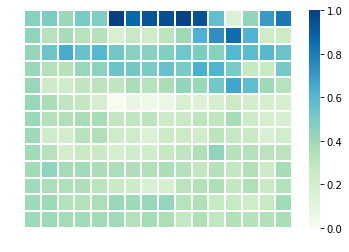

In [33]:
# Put this into a heatmap
_min = np.amin(mfcc)
_max = np.amax(mfcc)
mfcc = (mfcc - _min) / (_max - _min)


plt.figure(figsize = (6,4))
sns.heatmap(mfcc, cmap = 'GnBu', linewidth = 1)
plt.axis('off')
plt.savefig('figures/mfccs.png')

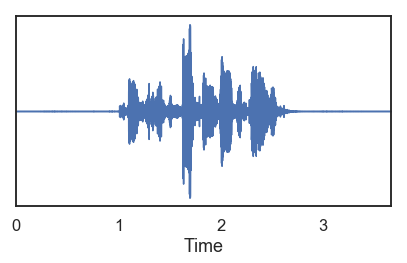

In [125]:
# Show the waveform without noise-floor detection
y, sr = librosa.load(filename)

plt.figure(figsize=(6,4))
librosa.display.waveplot(y, sr)
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/waveform.png')

In [46]:
classes = pd.DataFrame({'emotion': ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']})
classes

,emotion
0,neutral
1,happy
2,sad
3,angry
4,fearful
5,disgusted
6,surprised


In [37]:
results = pd.read_csv('test_results.csv')

results.drop(columns = 'Unnamed: 0', inplace = True)

In [40]:
results['correct'] = results['prediction'] == results['ground_truth']

In [51]:
test_dist = results['ground_truth'].value_counts()
correct_dist = results[results['correct'] == True]['ground_truth'].value_counts()

In [100]:
total_acc = results[results['correct'] == True].shape[0] / results.shape[0]

acc = []

for i in range(7):
    acc.append(correct_dist[i] / test_dist[i])

acc = acc
acc = [round(x*100,2) for x in acc]
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

df_acc = pd.DataFrame({'emotion': emotions, 'accuracy': acc})
df_acc.sort_values(by = 'accuracy', ascending = False, inplace = True)

emos = list(df_acc['emotion']) + ['Total']
accs = list(df_acc['accuracy']) + [100*total_acc]

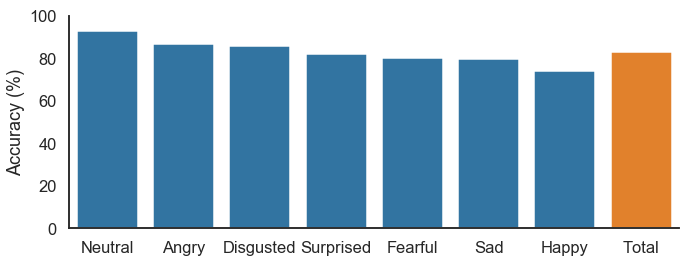

In [112]:
plt.figure(figsize=(10,4))
sns.set(style = 'white')
sns.set_context('talk')
sns.barplot(emos, accs, palette = ['#1f77b4','#1f77b4','#1f77b4','#1f77b4','#1f77b4',
                                   '#1f77b4','#1f77b4','#ff7f0e'])
sns.despine()
plt.ylim((0,100))
#plt.xlabel('Emotions')
#plt.xticks(rotation = 75)
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.savefig('figures/model_accuracy');

In [90]:
df_acc

,emotion,accuracy
0,Neutral,92.62
3,Angry,86.78
5,Disgusted,85.61
6,Surprised,81.74
4,Fearful,80.00
2,Sad,79.73
1,Happy,74.14


In [81]:

p = figure(x_range=emotions, plot_height=250, title="Accuracy",
           toolbar_location=None, tools="")

p.vbar(x = 'emotion', top = 'accuracy', source = df_acc, width = 0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = 100

tooltips = [
    ("Emotion", "@emotion"),
    ("Accuracy", "@accuracy")
]

hover = HoverTool(tooltips=tooltips)
p.add_tools(hover)

show(p)